# Education Data Analysis - Corrected

Cleaned pipeline with proper decimal conversion for grade columns.

In [120]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [121]:
# Load secondary data (first file)
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[0])

secondary_data = []
with open(csv_path) as data:
    reader = csv.reader(data)
    for row in reader:
        secondary_data.append(row)
    data.close()

df_S = pd.DataFrame(secondary_data)

# Load primary data (second file)
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[1])

primary_data = []
with open(csv_path) as data:
    reader = csv.reader(data)
    for row in reader:
        primary_data.append(row)
    data.close()

df_P = pd.DataFrame(primary_data)

In [122]:
# Set first row as header
df_P.columns = df_P.iloc[0]
df_P = df_P[1:]
df_P.reset_index(drop=True, inplace=True)

df_S.columns = df_S.iloc[0]
df_S = df_S[1:]
df_S.reset_index(drop=True, inplace=True)

In [123]:
# Keep only students present in both datasets
df = pd.DataFrame({'CODI_ALUMNE': pd.concat([df_P['CODI_ALUMNE'], df_S['CODI_ALUMNE']]).unique()})
df['in_P'] = df['CODI_ALUMNE'].isin(df_P['CODI_ALUMNE'])
df['in_S'] = df['CODI_ALUMNE'].isin(df_S['CODI_ALUMNE'])
matching = df[df['in_P'] & df['in_S']]

df_P = df_P[df_P['CODI_ALUMNE'].isin(matching['CODI_ALUMNE'])].copy()
df_S = df_S[df_S['CODI_ALUMNE'].isin(matching['CODI_ALUMNE'])].copy()

df_P.reset_index(drop=True, inplace=True)
df_S.reset_index(drop=True, inplace=True)

In [124]:
def convert_grades_to_numeric(df, prefix='P'):
    """
    Convert grade columns from comma-separated strings to numeric floats.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    prefix : str
        Column prefix to identify grade columns (default: 'P')
    
    Returns:
    --------
    list : Column names that were converted
    """
    grade_cols = [c for c in df.columns if c.startswith(prefix) and df[c].dtype == 'object']
    
    for col in grade_cols:
        # Replace comma with dot for decimal conversion
        s = df[col].astype(str).str.replace(',', '.', regex=False)
        # Convert to numeric (invalid parsing becomes NaN)
        df[col] = pd.to_numeric(s, errors='coerce')
    
    return grade_cols

# Apply conversion separately to Primary and Secondary
converted_P = convert_grades_to_numeric(df_P, prefix='P')
converted_S = convert_grades_to_numeric(df_S, prefix='P')

print(f"Converted {len(converted_P)} columns in Primary")
print(f"Converted {len(converted_S)} columns in Secondary")

Converted 24 columns in Primary
Converted 28 columns in Secondary


In [125]:
# ===============================
# Analysis: Primary Education
# ===============================
df_math_P = df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', 'PMAT']].drop_duplicates(subset='CODI_ALUMNE')
df_math_P['MES_NAIXEMENT'] = pd.Categorical(df_math_P['MES_NAIXEMENT'], 
                                            categories=[str(i) for i in range(1, 13)], ordered=True)
df_math_P['snapshot'] = 'Primary'

# Summary statistics for Primary
print("=" * 50)
print("PRIMARY EDUCATION - Mathematics (PMAT)")
print("=" * 50)
print(f"Total students: {len(df_math_P)}")
print(f"Mean grade: {df_math_P['PMAT'].mean():.2f}")
print(f"Median grade: {df_math_P['PMAT'].median():.2f}")
print(f"Std Dev: {df_math_P['PMAT'].std():.2f}")
print(f"Min: {df_math_P['PMAT'].min():.2f}")
print(f"Max: {df_math_P['PMAT'].max():.2f}")
print(f"25th percentile: {df_math_P['PMAT'].quantile(0.25):.2f}")
print(f"75th percentile: {df_math_P['PMAT'].quantile(0.75):.2f}")
print()

PRIMARY EDUCATION - Mathematics (PMAT)
Total students: 251748
Mean grade: 79.37
Median grade: 82.33
Std Dev: 15.12
Min: 2.59
Max: 100.00
25th percentile: 70.53
75th percentile: 91.05



In [126]:
# ===============================
# Analysis: Secondary Education
# ===============================
df_math_S = df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', 'PMAT']].drop_duplicates(subset='CODI_ALUMNE')
df_math_S['MES_NAIXEMENT'] = pd.Categorical(df_math_S['MES_NAIXEMENT'], 
                                            categories=[str(i) for i in range(1, 13)], ordered=True)
df_math_S['snapshot'] = 'Secondary'

# Summary statistics for Secondary
print("=" * 50)
print("SECONDARY EDUCATION - Mathematics (PMAT)")
print("=" * 50)
print(f"Total students: {len(df_math_S)}")
print(f"Mean grade: {df_math_S['PMAT'].mean():.2f}")
print(f"Median grade: {df_math_S['PMAT'].median():.2f}")
print(f"Std Dev: {df_math_S['PMAT'].std():.2f}")
print(f"Min: {df_math_S['PMAT'].min():.2f}")
print(f"Max: {df_math_S['PMAT'].max():.2f}")
print(f"25th percentile: {df_math_S['PMAT'].quantile(0.25):.2f}")
print(f"75th percentile: {df_math_S['PMAT'].quantile(0.75):.2f}")
print()

SECONDARY EDUCATION - Mathematics (PMAT)
Total students: 251748
Mean grade: 66.62
Median grade: 68.25
Std Dev: 20.11
Min: 0.00
Max: 100.00
25th percentile: 52.08
75th percentile: 83.08



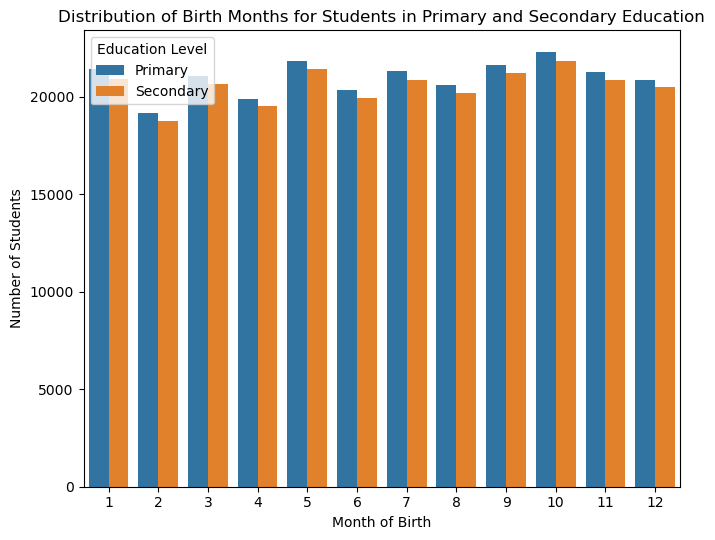

In [127]:
# ===============================
# Plot 1: Distribution of Birth Months
# ===============================
df_birth_P = df_P[['CODI_ALUMNE', 'MES_NAIXEMENT']].drop_duplicates()
df_birth_P['snapshot'] = 'Primary'

df_birth_S = df_S[['CODI_ALUMNE', 'MES_NAIXEMENT']].drop_duplicates()
df_birth_S['snapshot'] = 'Secondary'

# Combine for plotting only
df_birth_months = pd.concat([df_birth_P, df_birth_S], ignore_index=True)

# Order the months correctly, from 1 to 12
df_birth_months['MES_NAIXEMENT'] = pd.Categorical(df_birth_months['MES_NAIXEMENT'], 
                                                  categories=[str(i) for i in range(1, 13)], ordered=True)

plt.figure(figsize=(7, 5.5))
sns.countplot(data=df_birth_months, x='MES_NAIXEMENT', hue='snapshot')
plt.title('Distribution of Birth Months for Students in Primary and Secondary Education')
plt.xlabel('Month of Birth')
plt.ylabel('Number of Students')
plt.legend(title='Education Level', labels=['Primary', 'Secondary'])
plt.tight_layout()
plt.show()

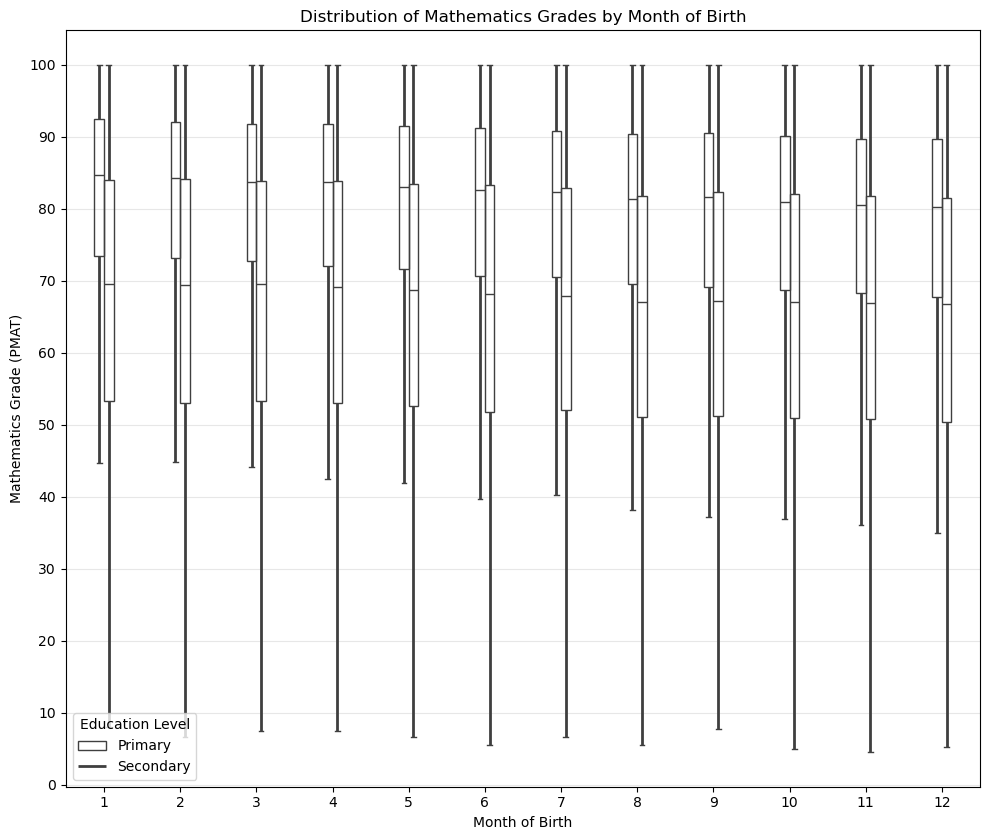

In [ ]:
# ===============================
# Plot 2: Mathematics Grades by Birth Month (Violin Distribution)
# ===============================
# Combine dataframes for plotting only
df_math_grades = pd.concat([df_math_P, df_math_S], ignore_index=True)

# Order the months correctly, from 1 to 12
df_math_grades['MES_NAIXEMENT'] = pd.Categorical(df_math_grades['MES_NAIXEMENT'], 
                                                 categories=[str(i) for i in range(1, 13)], ordered=True)

plt.figure(figsize=(10, 8.5))
# Add box with error bars inside violin plots
sns.violinplot(data=df_math_grades, x='MES_NAIXEMENT', y='PMAT', hue='snapshot', 
               palette='Set2', split=True, inner='quartile', linewidth=1.5)

sns.boxplot(
    data=df_math_grades,
    x='MES_NAIXEMENT',
    y='PMAT',
    hue='snapshot',
    showcaps=True,
    boxprops={'facecolor':'none', 'zorder':3},
    showfliers=False,
    whiskerprops={'linewidth':2},
    width=0.25
)

# Set y-axis ticks every 10 points
plt.yticks(range(0, 101, 10))

plt.title('Distribution of Mathematics Grades by Month of Birth')
plt.xlabel('Month of Birth')
plt.ylabel('Mathematics Grade (PMAT)')
plt.legend(title='Education Level', labels=['Primary', 'Secondary'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_20632/2445469921.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_stats_P = df_math_P.groupby('MES_NAIXEMENT')['PMAT'].agg(['mean', 'std', 'count']).reset_index()
/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_20632/2445469921.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_stats_S = df_math_S.groupby('MES_NAIXEMENT')['PMAT'].agg(['mean', 'std', 'count']).reset_index()


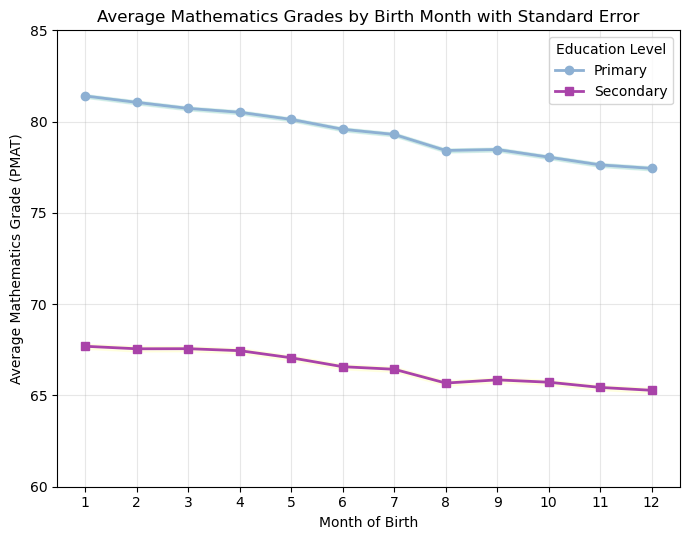

In [140]:
# ===============================
# Plot 3: Average Mathematics Grades by Birth Month with Error Bars
# ===============================
# Calculate mean and standard error for each birth month and education level
df_stats_P = df_math_P.groupby('MES_NAIXEMENT')['PMAT'].agg(['mean', 'std', 'count']).reset_index()
df_stats_P['se'] = df_stats_P['std'] / np.sqrt(df_stats_P['count'])
df_stats_P['snapshot'] = 'Primary'

df_stats_S = df_math_S.groupby('MES_NAIXEMENT')['PMAT'].agg(['mean', 'std', 'count']).reset_index()
df_stats_S['se'] = df_stats_S['std'] / np.sqrt(df_stats_S['count'])
df_stats_S['snapshot'] = 'Secondary'


# Convert month to numeric for plotting
df_stats_P['month_num'] = df_stats_P['MES_NAIXEMENT'].astype(str).astype(int)
df_stats_S['month_num'] = df_stats_S['MES_NAIXEMENT'].astype(str).astype(int)

plt.figure(figsize=(7, 5.5))

# Plot Primary data
plt.plot(df_stats_P['month_num'], df_stats_P['mean'], 
         marker='o', linewidth=2, label='Primary', color="#8DB0D3")
plt.fill_between(df_stats_P['month_num'], 
                  df_stats_P['mean'] - df_stats_P['se'], 
                  df_stats_P['mean'] + df_stats_P['se'], 
                  alpha=0.3, color='#8DD3C7')

# Plot Secondary data
plt.plot(df_stats_S['month_num'], df_stats_S['mean'], 
         marker='s', linewidth=2, label='Secondary', color="#A943A9")
plt.fill_between(df_stats_S['month_num'], 
                  df_stats_S['mean'] - df_stats_S['se'], 
                  df_stats_S['mean'] + df_stats_S['se'], 
                  alpha=0.3, color='#FFFFB3')


plt.xlabel('Month of Birth')
plt.ylabel('Average Mathematics Grade (PMAT)')
plt.title('Average Mathematics Grades by Birth Month with Standard Error')
plt.xticks(range(1, 13))
plt.yticks(range(60, 86, 5))
# Set yrange between 60 and 85
plt.ylim(60, 85)
plt.legend(title='Education Level')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
